In [80]:
import numpy as np
import pytest
from scipy.stats import ks_2samp
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from pathlib import Path
import seaborn as sns
import scipy
import sklearn_pandas
import sklearn
import fast_ml
import tqdm
import scipy.stats as stats
import cufflinks as cf
import plotly_express as px
import ipywidgets
import plotly.graph_objs as go
import pgmpy
from ngboost import NGBRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt import BayesSearchCV
import shap

from sklearn.preprocessing import OrdinalEncoder,MinMaxScaler,LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeRegressor

In [81]:

pathToCSV = Path("C:/Users/jakub/OneDrive/Documents/task1.csv") #a way to use a path regardless of system
mainFrame = pd.read_csv(pathToCSV)
mainFrame
nan = np.nan

# Checking data quality

First it will be checked weather data in all columns met given constraints for example wheather numerical data is always in given range
if not, how frequently. Presence and number of null values in each column will also be checked.
If The  project would be done on Azure this will be completed by azure data validation in data factory or synapse analytics

In [82]:
#columns with binary values (both strings)
listOfBinary = [['school' , ['GP', 'MS']],
    ['sex', ['F', 'M']],
    ['address', ['U', 'R']],
    ['famsize', ['LE3','GT3']],
    ['Pstatus', ['T','A']]]
#columns with yes/no values
listOfYesNo=  [ ['schoolsup', ['yes','no']],
    ['famsup', ['yes','no']],
    ['paid', ['yes','no']],
    ['activities', ['yes','no']],
    ['nursery', ['yes','no']],
    ['higher', ['yes','no']],
    ['internet', ['yes','no']],
    ['romantic', ['yes','no']]]
# limited possible of string values (but more than 2 )
listOfCatogorical = [    ['Mjob', ['teacher','health','services','at_home','other']],
    ['Fjob', ['teacher','health','services','at_home','other']],
    ['reason', ['home','reputation','course','other']],
    ['guardian', ['mother','father', 'other']]]

#storing constraints for column with known limited range of possible string values first entry of each sub list is always a name of a column
listOfStringConstraints=listOfBinary+listOfYesNo+listOfCatogorical




# storing numerical constraints for given columns first entry of each sub list is always a name of a column second entry is list with lower and upper bound
listOfNumericalRangeConstraints = [
    ['age', [15,22]  ],
    ['absences' ,[0,93]],
    ['G1' ,[0,20]],
    ['G2' ,[0,20]]
]
#storing discrete range of possible values that a column is allowed to have
listOfDiscreteNumericalConstraints = [
    ['Medu', [0,1,2,3,4]  ],
    ['Fedu', [0,1,2,3,4]],
    ['traveltime', [1,2,3,4]],
    ['studytime', [1,2,3,4]],
    ['failures', [0,1,2,3,4]], #(numeric: n if 1<=n<3, else 4) is imprecise yet it is logical that number 0 should be allowed
    ['famrel', [1,2,3,4,5]],
    ['freetime', [1,2,3,4,5]],
    ['goout', [1,2,3,4,5]],
    ['Dalc', [1,2,3,4,5]],
    ['Walc', [1,2,3,4,5]],
    ['health', [1,2,3,4,5]]
]
#output variable data
outPutDat =  ['G3' ,[0,20]]

In [83]:

def createQueryStrings (listOfPrimRules : list[str], columnName :str) -> list[str]:
    """
    given list of queries related to given column and column name constructs list of queries

    Returns: list of query strings where first is column name , second  querying for incompatibility with constraints and third  for Nan values

   """
    return [columnName," & ".join(listOfPrimRules) + f" & {columnName}.notna() " , f"{columnName}.isna() "]


In [84]:
def getStringConstraints(listOfData : list ) -> list[str]:
    """
    given  list of data (first entry is a column name second is a list of constraints) creates list
    for querying constraint of possible string values
    """
    return list(map(lambda innerStr: f"{listOfData[0]} != \'{innerStr}\' ", listOfData[1]))


innerListA = ['sex', ['F', 'M']]#just for testing
#values checked manually earlier
assert mainFrame.query( createQueryStrings(getStringConstraints(innerListA),innerListA[0])[2]  ).shape[0] == 17
assert mainFrame.query( createQueryStrings(getStringConstraints(innerListA),innerListA[0])[1]  ).shape[0] == 0

In [85]:
def getRangeConstraints(listOfData : list ) -> list[str]:
    """
    given  list of data (first entry is a column name second is a list containg upper and lower bound
    returns string  checking how many column values are outside of this range
    """
    return [f"({listOfData[0]} < {listOfData[1][0]}  & {listOfData[0]}.notna() )  | {listOfData[0]} >  {listOfData[1][1]}"]


innerListB = ['age', [15,22]  ]#just for testing
#values checked manually earlier
assert mainFrame.query( createQueryStrings(getRangeConstraints(innerListB),innerListB[0])[2]  ).shape[0] == 0
assert mainFrame.query( createQueryStrings(getRangeConstraints(innerListB),innerListB[0])[1]  ).shape[0] == 0

In [86]:
def getDiscreteNumbersConstraints(listOfData : list ) -> list[str]:
    """
    given  list of data (first entry is a column name second is a list containg upper and lower bound
    returns string  checking how many column values are outside of this range
    """
    return list(map(lambda innerNumb: f"{listOfData[0]} != {innerNumb} ", listOfData[1]))




innerListC = ['Medu', [0,1,2,3,4]  ]#just for testing
#values checked manually earlier
assert mainFrame.query( createQueryStrings(getDiscreteNumbersConstraints(innerListC),innerListC[0])[2]  ).shape[0] == 12
assert mainFrame.query( createQueryStrings(getDiscreteNumbersConstraints(innerListC),innerListC[0])[1]  ).shape[0] == 0

In [87]:
"""
below we are mapping data about constraints to a query strings that can be executed against the pandas dataframe
"""
#
la =  list(map(lambda innerList : createQueryStrings(getStringConstraints(innerList),innerList[0])  ,listOfStringConstraints))
lb = list(map(lambda innerList : createQueryStrings(getRangeConstraints(innerList),innerList[0])  ,listOfNumericalRangeConstraints))
lc = list(map(lambda innerList : createQueryStrings(getDiscreteNumbersConstraints(innerList),innerList[0])  ,listOfDiscreteNumericalConstraints))
outputConstr = createQueryStrings(getRangeConstraints(outPutDat),outPutDat[0])
listOfQueries = la +lb+lc






In [88]:
def checkRestraintCompliance(dataFrame : pd.DataFrame, constraints:list[list[str]] ) -> pd.DataFrame:
    """given dataframe and list of constraints returns numbers of rows that do not keep those constraints
    Separately we are considering the NaN values separately

    Parameters:
    dataFrame (pd.DataFrame): dataframe with columns we want to check
    constraints(list[list[string]]) : list of constraints
    inner list has three entries first is column name second is a  query that checks for constraints
    third is a query for presence of nan values

    Returns:
    pd.DataFrame: Returning dataframe that contains in first column name of a column from source dataframe
    in second number of columns that do not meet restrictions (not counting NaN) and in third NaN values

   """
    threeDimList = list(map(lambda qStrings  :[qStrings[0],dataFrame.query(qStrings[1]).shape[0],dataFrame.query(qStrings[2]).shape[0] ]     ,constraints))

    return pd.DataFrame(threeDimList, columns = ['columnName', 'outOfConstraints','NanSum']).sort_values(['outOfConstraints','NanSum'], ascending=False)
checkRestraintCompliance(mainFrame,listOfQueries )

,columnName,outOfConstraints,NanSum
1,sex,0,17
21,Medu,0,12
0,school,0,0
2,address,0,0
3,famsize,0,0
4,Pstatus,0,0
5,schoolsup,0,0
6,famsup,0,0
7,paid,0,0
8,activities,0,0


Now presence and number of duplicate rows will be established

In [89]:
mainFrame.duplicated().any()

False

### Data Quality conclusions
AS we see all the data values meet constraints NaN values are present only in sex and Medu columns,
 also there are no duplicated rows

## Data Split and setting types
In order to avoid making assumptions that we could impose on a model all later steps will be done in
spearation, and we will explore only training and validation sets leaving test set for
 final assesment of predictive model

In [90]:
from fast_ml.model_development import train_valid_test_split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(mainFrame, target = 'G3',
                                                                            train_size=0.7, valid_size=0.15, test_size=0.15)

Setting proper types for pandas dataframe

In [91]:
#first we will design dictionary that will store data about types
categor = listOfDiscreteNumericalConstraints+ listOfStringConstraints
categoricMap= dict( zip(list(map(lambda x : x[0], categor)), ['category' for i in range(len(categor))]  ) )

For convenience we will define also 2 dimension numpy array that will make studying interactions between
column wise data simpler


In [92]:
def getInfoForInterColumnIter(df : pd.DataFrame) -> pd.DataFrame :
    """
    given dataframe analyzes column names and their types and returns appropriate tuples for later iteration by other functions
    :param df: pandas dataframe which we will want to iterate over
    :return (pd.DataFrame) : with cartesian product of column names and marking is given element categorical or not
    """
    colNames = list(df.columns)
    #names of categoric columns
    categorNames = list(categoricMap.keys())
    # Cartesian product of string elements
    # first 2  entries are names of columns third marks is first column is categorical and fourth marks if second column name is categorical
    res = [ [[sub1, sub2 , sub1 in categorNames, sub2 in  categorNames]
            for sub1 in colNames] for sub2 in colNames]
    return pd.DataFrame(res, columns = list(df.columns) ,index = list(df.columns) )




# Primary data exploration

In [93]:
primExp= pd.concat([X_train.copy(), y_train.copy()],axis = 1)
primExp= primExp.astype(categoricMap)

In [94]:
primExp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 335 to 259
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      276 non-null    category
 1   sex         266 non-null    category
 2   age         276 non-null    int64   
 3   address     276 non-null    category
 4   famsize     276 non-null    category
 5   Pstatus     276 non-null    category
 6   Medu        269 non-null    category
 7   Fedu        276 non-null    category
 8   Mjob        276 non-null    category
 9   Fjob        276 non-null    category
 10  reason      276 non-null    category
 11  guardian    276 non-null    category
 12  traveltime  276 non-null    category
 13  studytime   276 non-null    category
 14  failures    276 non-null    category
 15  schoolsup   276 non-null    category
 16  famsup      276 non-null    category
 17  paid        276 non-null    category
 18  activities  276 non-null    category
 19  nurser

In [95]:
primExp.describe()


,age,absences,G1,G2,G3
count,276.000000,276.000000,276.000000,276.000000,276.000000
mean,16.583333,5.942029,11.003623,10.916667,10.623188
std,1.277901,8.653128,3.310038,3.643716,4.456991
min,15.000000,0.000000,4.000000,0.000000,0.000000
25%,16.000000,0.000000,8.000000,9.000000,9.000000
50%,16.000000,4.000000,11.000000,11.000000,11.000000
75%,17.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,75.000000,19.000000,19.000000,20.000000


# Data Cleaning and preparation

### First the type of columns will be set  and encoded into numeric data (we will use pipeline for greater flexibility)


In [96]:
toExplore = X_train.copy()
colNames = toExplore.columns
#to be able to asses column number by name
colNameDict = dict(zip(colNames,[i for i in range(len(colNames))] ))



Defining Tranformations

In [97]:
class TransformingX :
    """
    class encompassing constants and functions  needed to transform data - similar to sklearn pipeline,
     but return the pandas data frame instead of numpy array and enables decoding columns that were encoded in ordinal manner
   """
    #for  listOfBinary listOfYesNo and listOfCatogorical we will apply the imputer and ordinal encoding
    cateGoricTransforms = []
    #for listOfNumericalRangeConstraints  the min max scaling and box-cox transformwill be applied  to make data more resembling gaussian distribution what will make later statistical tests perform better
    numerical = []
    #for categorical values that are already numerical we need to apply only imputation of missing values
    categoricalNumerical = []
    def __init__(self):
        self.cateGoricTransforms = list(map( lambda x : ([x[0]],[SimpleImputer(strategy='most_frequent') ,OrdinalEncoder()] ) ,listOfStringConstraints))
        self.numerical = list(map( lambda x : ([x[0]], [MinMaxScaler(feature_range=(1, 2)) ,PowerTransformer(method='box-cox') ] ) ,listOfNumericalRangeConstraints))
        self.categoricalNumerical = list(map( lambda x : ([x[0]],SimpleImputer(strategy='most_frequent') ) ,listOfDiscreteNumericalConstraints))

    def transformX(self,frame : pd.DataFrame)-> pd.DataFrame:
        """given dataframe and list of defined transforms applies transforms and returns dataframe additionaly
        uses dictionary of types (global variable) to proper types to resulting pandas data frame

        Parameters:
        dataFrame (pd.DataFrame): dataframe with columns we want to transform

        Returns:
        pd.DataFrame: Returning transformed dataframe
       """
        mapper = sklearn_pandas.DataFrameMapper(self.cateGoricTransforms+ self.numerical+ self.categoricalNumerical, df_out=True)
        out = mapper.fit(frame).transform(frame)\
            .astype(categoricMap)
        return out

    def inverseOrdinalTransform(self,frame : pd.DataFrame)-> pd.DataFrame:
        """given dataframe it will reverse ordinal encoding done earlier by the transformX function

        Parameters:
        dataFrame (pd.DataFrame): dataframe with columns we want to transform (inverse transformation)

        Returns:
        pd.DataFrame: Returning transformed (inverse transformation) dataframe
       """
        #we iterate over ordinal encoders we used and we reverse for each its tranformation (non efficientbut sufficient for this dataset)
        for tupl in self.cateGoricTransforms :
            frame[tupl[0][0]]= tupl[1][1].inverse_transform(pd.DataFrame(frame[[tupl[0][0]]]))
        return frame

In [98]:
#as we know values we can use single transformer always
mainYScaler = MinMaxScaler(feature_range=(1, 2))
mainYScaler.fit(np.array(list(range(0,21))).flatten().reshape(-1, 1))


def transformY(arr : np.ndarray, BoxCoxTransformer)-> pd.DataFrame:
    """given dataframe with output variable will apply minmax and box cox transform

    Parameters:
    dataFrame (pd.DataFrame): dataframe with columns we want to transform

    Returns:
    pd.DataFrame: Returning transformed dataframe
    """
    frame = pd.DataFrame(arr, columns=['G3'])
    a = mainYScaler.transform(frame)
    b= BoxCoxTransformer.fit_transform(a)
    frame = pd.DataFrame(b, columns=['G3'])
    return frame


# Futher Data Exploration
In order to explore the data we will first fuse the training data and training labels (after We applied transformations)
Most important part of visualization will analyze relations between variables on the basis of Mutual information criterion
,which lately increases its popularity as  better correlation metric than traditional ones like pearson or spearman correlations [1]

In [99]:
# preparing data for exploration

toExploreTransformX = TransformingX()
Xeexp = toExploreTransformX.transformX(toExplore)
#list needed for transforming Y

PowerTransformer(method='box-cox')

trExp= pd.concat([Xeexp, y_train.copy()],axis = 1)

We can analyze pairwise relations to check for emerging trends

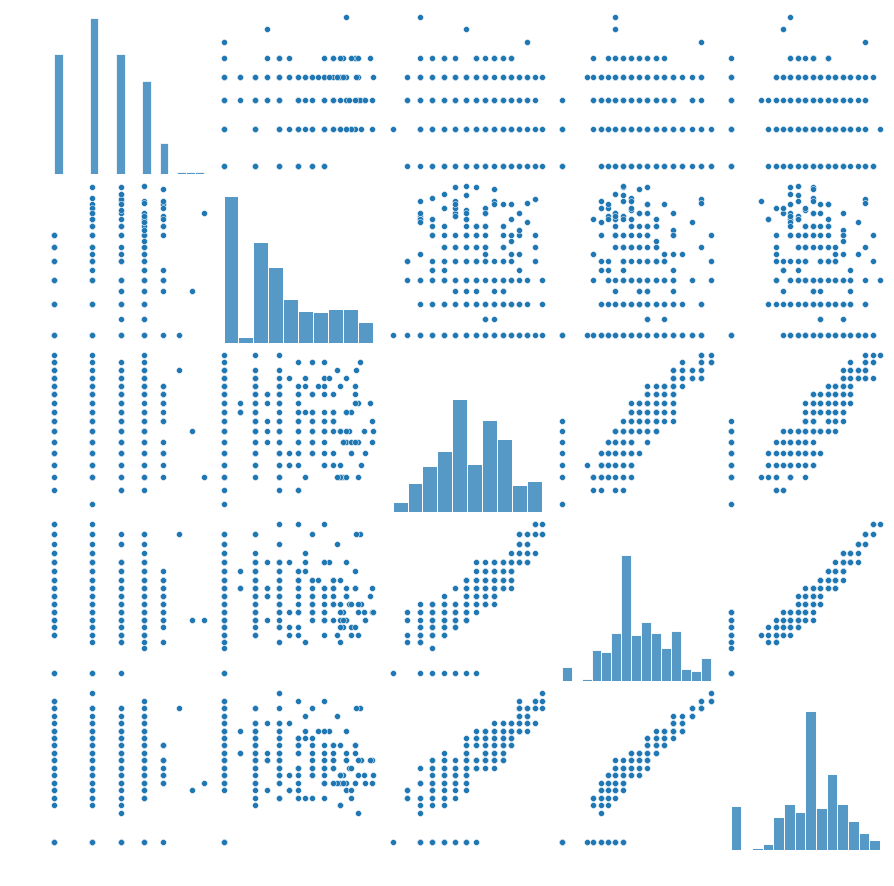

In [100]:
sns.pairplot(trExp)

We can clearly see the linear correlation between G1,G2 and G3

First we will create correlation matrix using mutual information
(as it is good for all numerical and  categorical variables )


In [101]:
from sklearn.metrics import mutual_info_score

#for convinience we use created earlier function for cartesian product of names
mutualInfoCorr = getInfoForInterColumnIter(trExp)\
    .applymap( lambda cell:mutual_info_score(trExp[cell[0]], trExp[cell[1]])  )

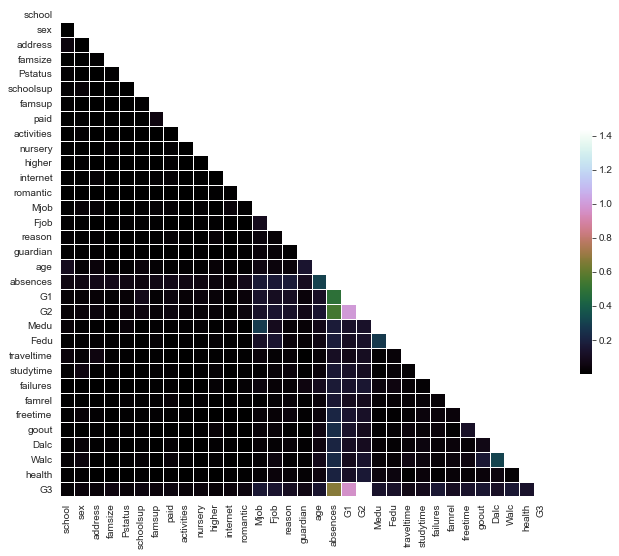

In [102]:
def CorrMtx(df, dropDuplicates = True):
    """
    just a function that gets symmetric matrix nd formats it in visually pleasing way
    """

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.color_palette("cubehelix", as_cmap=True)
        #sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap,
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap,
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

CorrMtx(mutualInfoCorr)

From the picture above we clearly see that we have high correlation between G1,G2 and G3 scores -
 this obscure somewhat other correlations so we will
remove G1 and G2 from analysis for a moment
additionally we will cluster correlations to see groups of variables that has high mutual information

In [103]:
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array :pd.DataFrame , inplace=False)-> pd.DataFrame:
    """
    Rearranges the matrix with mutual information data , corr_array, so that groups of highly
    correlated variables are next to eachother adapted from https://wil.yegelwel.com/cluster-correlation-matrix/

    Parameters
    ----------
    corr_array : pandas.DataFrame  a NxN  matrix with mutual information data

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold,
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

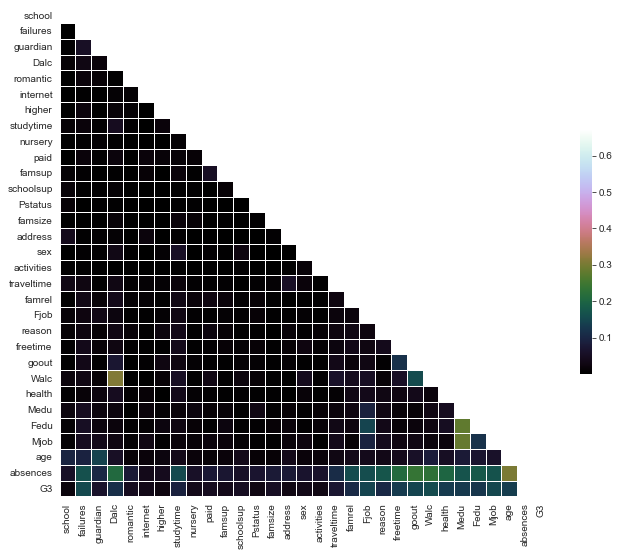

In [104]:
trExpB = trExp.copy()
trExpB = trExpB.drop(['G1', 'G2'], axis=1)
mutualInfoCorr2 = getInfoForInterColumnIter(trExpB)\
    .applymap( lambda cell:mutual_info_score(trExpB[cell[0]], trExpB[cell[1]])  )

CorrMtx(cluster_corr(mutualInfoCorr2))

We can clearly se association between parents alcohol consumption,also absences are highly related to other informations of social well being.
What is of our highest intrest is the mutual information og G3 with other variables and this will be now checked

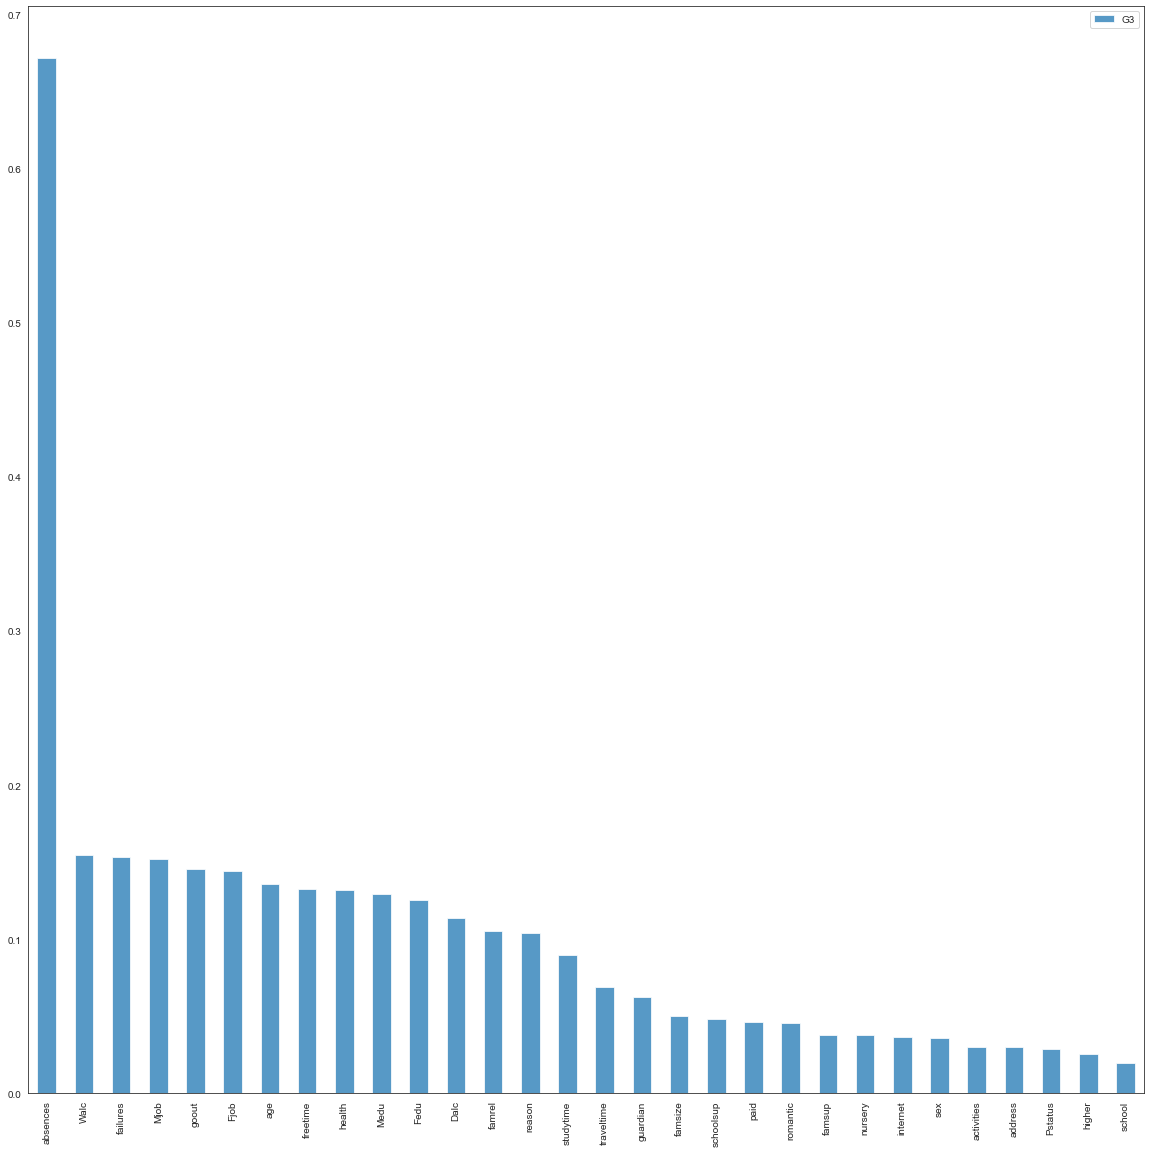

In [105]:
mutualInfoCorr2[['G3']].drop(['G3']).sort_values(by=['G3'], ascending=False)\
    .plot(kind='bar',alpha=0.75, rot=0,figsize=(20,20))
plt.xticks(rotation=90)

plt.show()

Clearly absences are dominating, yet also failures and parents job type is highly related to G3

# Feature selection, outlier removal and feature engineering

### Feature engineering
On the basis of data exploration 2 hypothesis were drawn

1) G1 and G2 has high mutual information hence some summary statistic like average of those two should still hold similar infomration (measured by mutual information)
 as in non modified case
2) parent alcohol uptake is intra correleted,hence hypothesis is that having information about weather any of the parents has increased alcohol consumption will be sufficient
The mutual information (MI) is a measure of the amount of information that one random variable has about another variable[2]

To check weather those hypotheses has any credibility we will incorporate both test sets with this transformation and without during hyperparameter tuning.


### Feature selection
I will concentrate on traditional feature selection understood as dropping those features that has
low probability of impacting predictive performance of the model in order to improve speed and reliability of a model.
Dimensionality reduction will not be incorporated in order to keep the interpretability
of the model.

Modern approach that is both easy to use and efficient is RFE (recursive feature elimination)
Literature points out particularly to the RFE with use of the random tree forest [3].
One problem that is not easy to solve is setting optimal number of features to keep.
This can be achieved by performing cross-validation evaluation of diffrent numbers of
features and is implemented in RFECV.

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

###  Removing outliers
For outlier detection also performant algorithms exists one used here will be based on
 sckit learn LocalOutlierFactor class which is the adaptation of K nearest neighbours algorithm to outlier detection.

In [107]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()

In order to be able to use the same transformations to all parts of the dataset the class encompassing the modifications will be written below

In [108]:
class TransformingXFuther :
    """
    It uses defined earlier TransformingX class to augment it with new functionality of feature selection, outlier removal and feature engineering
    random feature extraction would be performed by supplied object via constructor
    """
    lof = LocalOutlierFactor( )
    # needed to transform Y
    powTransf = PowerTransformer(method='box-cox')
    #list stroing diffrent choices of features  support boolean maps based on weather we engineered some features or not
    afterFeatureEngAndSelectrionList= []


    def trainRFE (self,Xframe : pd.DataFrame,Yframe: pd.DataFrame ,primTransform : TransformingX) :
        """
        In order to be able to consistently choose features in the train test and validation set we would
        train it on training set and apply evrywhere
        :param Xframe:  frame with data
        :param Yframe:  frame with labels
        :param primTransform:  object that is responsible for primary transformation of data

        """
        frameTransformed = primTransform.transformX(Xframe)
       #generating diffrent supports depending on generated features
        for comb in [[True,False],[True,True],[False,True],[False,False]] :
            aferEngineered= self.featureengineering(frameTransformed, comb[0],comb[1] )
            rfSupp = RFECV(estimator=RandomForestClassifier(random_state=0),min_features_to_select =14)\
                .fit(aferEngineered,Yframe  ).get_support(indices=False)
            self.afterFeatureEngAndSelectrionList.append(rfSupp)


    def featureengineering(self,frameTransformed : pd.DataFrame
                           ,toFuseG1G2 :bool
                           ,toFuseAlco :bool)-> pd.DataFrame:
        """given dataframes it perform feature engineering in this case fusing two  features

        Parameters:
        toFuseG1G2 - if true we will fus G1 and G2 column
        toFuseAlco- if true we will fus columns holding information about alcohol consumption in parents
        Xframe (pd.DataFrame): dataframe with columns we will take to tranform
        Returns:
        pd.DataFrame: Returning transformed X dataframe
       """
        if toFuseG1G2:
            frameTransformed['G1G2'] =(frameTransformed['G1'] + frameTransformed['G2'])/2
            frameTransformed= frameTransformed.drop(['G1', 'G2'], axis=1)
        if toFuseAlco :
            frameTransformed['DalcWalc'] =np.maximum(frameTransformed['Dalc'].to_numpy(). astype(int),frameTransformed['Walc'].to_numpy(). astype(int))
            frameTransformed=frameTransformed.drop(['Dalc', 'Walc'], axis=1)
        return frameTransformed





    def featureSelection(self,frameTransformed : pd.DataFrame,indexOfSupportList : int)-> pd.DataFrame:
        """given dataframes it transforms it what includes outlier removal and feature selection

        Parameters:
        Xframe (pd.DataFrame): dataframe with columns we want to transform - it holds independent variables
        indexOfSupportList (int) index in afterFeatureEngAndSelectrionList of FRE support
        Returns:
        pd.DataFrame: Returning transformed X dataframe
       """

        return frameTransformed.loc[:,self.afterFeatureEngAndSelectrionList[indexOfSupportList]]

    def outlierRemoval(self,frameTransformed : pd.DataFrame,Yframe : pd.DataFrame)-> list[pd.DataFrame]:
        """given dataframes it performs removal of rows that contain those outliers

        Parameters:
        Xframe (pd.DataFrame): dataframe with columns we want to transform - it holds independent variables
        Yframe (pd.DataFrame) holds dependent variable will be also tranformed

        Returns:
        [pd.DataFrame]: Returning list of transformed dataframe first with data second with label
       """

        #LocalOutlierFactor return 1 for each row that is not considered oulier and -1 for those that are it is converted to boolean array
        isNotOultier = list(map( lambda x: x==1 , self.lof.fit_predict(frameTransformed,Yframe.copy())))
        print("number of rows with outliers removed")
        print(len(list(filter(lambda x : x==False ,isNotOultier  )) )  )
        return [frameTransformed.loc[isNotOultier],Yframe.loc[isNotOultier] ]




    def transforrmFuther(self,Xframe : pd.DataFrame
                         ,Yframe : pd.DataFrame
                         ,primTransform : TransformingX)-> list[list[pd.DataFrame]]:
        """given dataframes it transforms it what includes outlier removal,
         feature selection and feature engineering

        Parameters:
        Xframe (pd.DataFrame): dataframe with columns we want to transform - it holds independent variables
        Yframe (pd.DataFrame) holds dependent variable will be also transformed
        primTransform (TransformingX) object used for primary data transformations
        Returns:
        [pd.DataFrame]: Returning 2 dimensional list of transformed dataframes
        in inner frames first is  with data second with target variable we get 4 such pairs with
        different "levels" of feature engineering as specified in list
        [[True,False],[True,True],[False,True],[False,False]]
       """
        frameTransformed = primTransform.transformX(Xframe)
        Ytansf = transformY(Yframe,self.powTransf)
        index =-1
        res = []
        for comb in [[True,False],[True,True],[False,True],[False,False]] :
            index +=1
            enigneered = self.featureengineering(frameTransformed, comb[0],comb[1] )
            fSel = self.featureSelection( enigneered,index)
            res.append(self.outlierRemoval(fSel,Ytansf ))
        return res




### Data storing
Below class able to store the  different combinations of transformed dataset will be written,
in order to be able to conveniently incorporate analysis of the data transformation, feature engineering and
feature selection into the hyperparameter tuning

In [109]:
#We apply transformations  to the data set parts
#training
primTransformTrain = TransformingX()
transFFuther = TransformingXFuther()
transFFuther.trainRFE(X_train.copy(),y_train.copy(), primTransformTrain )


transfromedFrameTrain = transFFuther.transforrmFuther(X_train.copy(), y_train.copy(),primTransformTrain)
trtrain = transfromedFrameTrain
#validation
primTransformVal = TransformingX()
transfromedFrameVal = transFFuther.transforrmFuther(X_valid.copy(), y_valid.copy(),primTransformVal)
trVal = transfromedFrameVal
#test
primTransformTest = TransformingX()
transfromedFrameTest = transFFuther.transforrmFuther(X_test.copy(), y_test.copy(),primTransformTest)
trTest = transfromedFrameTest


number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0
number of rows with outliers removed
0


# Predictive modelling
## Regression
The dependent variable G3 can have one of 20 values, so it can be modelled both using regression
and classification algorithms; Regression with the amount of data available has the advantage of
continuous output function which makes optimazation simpler for the algorithm,
and greater generalization what may be beneficial in situation where most combinations
of the variables are not present in the data.

On the basis of the literature for the datasets with
many categorical variables gradient boosted trees may be the model of choice [4].

More precisely
Author had chosen algorithm created in Stanford University of Natural gradient boosting [5] which is able to
 return instead of only point estimates probability distribution, is also very convenient in model interpretability

## Evaluation metric
Probabilistic regression and classification models are gaining popularity mainly because of the ability of the model the represent uncertainty by reporting variance of the distribution.
Yet becouse of it the evaluation metric should not be the simple comparing the modes of the distribution, but comparing full distributions.


A most popular algorithm for comapring probability distributions is KL-divergence yet
because of lack of the symmetry
and problem with output interpretability is not the best evaluation metrics.


In paper written by Gardner, Paul & Lord, Charles et al. [6] suggested metrics included MMD
 (without well-supported widely
 available implementation to the best knowledge of the author)
 or Kolmogorov distance which will be used in regression in this work.

Implementation of Kolmogorov distance was taken from work of Xiao Wei [7].
 MSE will be additional reported metric (because this is most frequently used metric and practitioners
  are used to this result).


## Hyperparameter Tuning

Regression trees are known for multitude of hyperparameters,
hence exhaustive search (grid search) may not be feasible
in such cases most widely used algorithm is Baysian hyperparameter tuning [8].

Apart from hyperparameters of the model additionally influence of the feature engineering,
and some aspact of data transformations will be established, and tuned.

Yet first to establish baseline model efficiency we will develop model of linear Regression.

In [134]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(trtrain[3][0], trtrain[3][1])  # perform linear regression
Y_pred = linear_regressor.predict(trVal[3][0])  # make predictions
test_MSE = mean_squared_error(Y_pred,trVal[3][1])
test_MSE

0.12457470697865217

## NGboost

In [112]:
# define the space of hyperparameters to search
search_space = list()

search_space.append(Real(0.5,1.0, name='minibatch_frac'))
search_space.append(Integer(2,20, name='min_samples_split'))
search_space.append(Real(0.00005,0.01, name='min_impurity_decrease'))
search_space.append(Real(0.5,1, name='minibatch_frac'))
search_space.append(Integer(1,3, name='max_depth'))
search_space.append(Integer(2,5, name='early stop'))
#is controlling parameters regulating feature engineering toFuseG1G2 toFuseAlco with such order as below
#[[True,False],[True,True],[False,True],[False,False]]
search_space.append(Integer(0,3, name='whichDataFeatures'))


In [113]:
def getModel(innerParams) :
    """
    Given dictionary of parameters it return the model
    :param params: dictionary of parameters
    :return:
    """
    train = trtrain[innerParams['whichDataFeatures']]
    valid= trVal[innerParams['whichDataFeatures']]
    base = DecisionTreeRegressor(criterion='friedman_mse',
                        max_depth = innerParams['max_depth'],
                        min_samples_split = innerParams['min_samples_split'],
                        min_impurity_decrease = innerParams['min_impurity_decrease'])
    ngb = NGBRegressor( Base = base
                        , verbose=False).fit(train[0], train[1], X_val=valid[0], Y_val=valid[1]
                                             , early_stopping_rounds=innerParams['early stop'])

    return ngb

In [126]:

kses = [] # store ks values
mses = [] # store ms values
paramsList= [] # store parameters


# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    ngb = getModel(params)
    valid= trVal[params['whichDataFeatures']]
    Y_preds = ngb.predict(valid[0])
    flatValY = valid[1].to_numpy().flatten()
    #test Mean Squared Error
    test_MSE = mean_squared_error(Y_preds, valid[1])
    mses.append(test_MSE)
    paramsList.append(params)
    ks = stats.ks_2samp( np.array(ngb.pred_dist(valid[0]).sample(len(valid))).flatten() ,flatValY)
    kses.append(ks)
    #skopt baysian optimazation tries to find arguments
    return ks[0]


# perform optimization
result = gp_minimize(evaluate_model, search_space)

## Model Results

In [127]:
mapped = list(map(lambda x : x[0], kses))
min_value = min(mapped)
min_index = mapped.index(min_value)
print("minimum ks statistic and p value (null hypothesis that 2 independent samples are drawn from the same continuous distribution)")
print(kses[min_index])
print("minimum MSE")
print(mses[min_index])
print("best params")
print(paramsList[min_index])
print("best params by bestParamsKs")

############## min MSE
min_value = min(mses)
min_index = mses.index(min_value)

print("minimum MSE")
print(mses[min_index])
print("best params")
print(paramsList[min_index])
print("best params by MSE")

minimum ks statistic and p value (null hypothesis that 2 independent samples are drawn from the same continuous distribution)
KstestResult(statistic=0.0847457627118644, pvalue=0.9346349826221044)
minimum MSE
0.10645746265753071
best params
{'minibatch_frac': 0.546218082555439, 'min_samples_split': 18, 'min_impurity_decrease': 0.006621120730547269, 'max_depth': 3, 'early stop': 3, 'whichDataFeatures': 1}
best params by bestParamsKs
minimum MSE
0.10406320649290084
best params
{'minibatch_frac': 0.7594726825649301, 'min_samples_split': 8, 'min_impurity_decrease': 0.007971214063544719, 'max_depth': 3, 'early stop': 5, 'whichDataFeatures': 1}
best params by MSE


In [116]:
#Storing
#bestParamsKs = {'minibatch_frac': 1.0, 'min_samples_split': 2, 'min_impurity_decrease': 0.01, 'max_depth': 3, 'early stop': 5, 'whichDataFeatures': 2}
bestParamsKs = {'minibatch_frac': 0.546218082555439, 'min_samples_split': 18, 'min_impurity_decrease': 0.006621120730547269, 'max_depth': 3, 'early stop': 3, 'whichDataFeatures': 1}
bestParamsMSE = {'minibatch_frac': 0.5167035741048001, 'min_samples_split': 10, 'min_impurity_decrease': 0.0038796685593390384, 'max_depth': 3, 'early stop': 5, 'whichDataFeatures': 1}

Below we define valid and train datasets - what is crucial for all prototyping phase valid meant validation set it was changed to test set just on the last evaluation

In [128]:
valid = trTest[bestParamsKs['whichDataFeatures']]
train = trTest[bestParamsKs['whichDataFeatures']]

In [129]:
ngbMinKs =  getModel(bestParamsKs)




flatValY = valid[1].to_numpy().flatten()
lengthOfValSet = len(flatValY)

Y_preds = ngbMinKs.predict(valid[0])


Y_dists = ngbMinKs.pred_dist(valid[0])

paramsCalculated = Y_dists[0:lengthOfValSet].params


ks = stats.ks_2samp( np.array(ngbMinKs.pred_dist(valid[0]).sample(lengthOfValSet)).flatten() ,flatValY)
mse = mean_squared_error(Y_preds, valid[1])
print("ks ",ks, "MSE",mse  )

ks  KstestResult(statistic=0.12333333333333334, pvalue=0.30589066667276743) MSE 0.14598775333577263


## Plotts


In [130]:
def plotmodelResults (original : list ,means : list, loweBound : list ,upperBound: list  ):
    """
    Plotting the target points, predicted points and 1 standard deviation from the model points
    red line true data
    dashed blue predicted mean
    grey area model plotted standard deviation from the mean
    :param original: original target variables
    :param means: predicted values
    :param loweBound: predicted values minus standard deviation
    :param upperBound: predicted values plus standard deviation
    :return: plots to the console
    """
    paramsStyle = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
    plt.rcParams.update(paramsStyle)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)


    plt.plot(original, color = 'red', linewidth=3)
    plt.plot( means,color = 'blue', linewidth=3, linestyle='dashed')

    plt.fill_between(list(range(0,lengthOfValSet)),
                    loweBound, upperBound,
                     color='gray', alpha=0.2)
    plt.yticks(np.arange(min(loweBound), max(upperBound), 3))

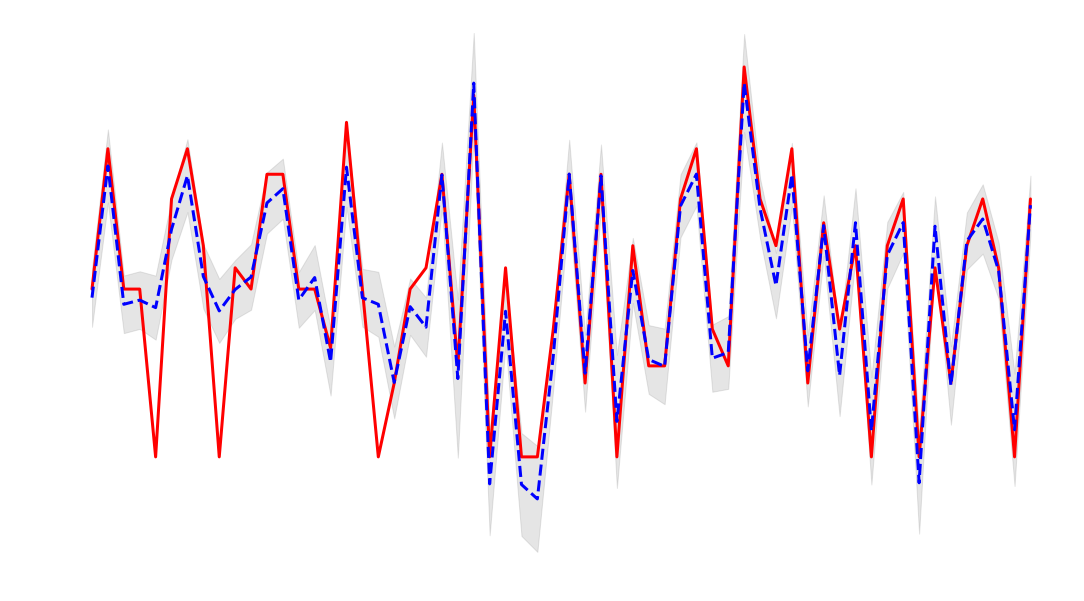

In [131]:
plotmodelResults(valid[1]['G3'].to_numpy(), paramsCalculated['loc'], paramsCalculated['loc'] - paramsCalculated['scale'] ,paramsCalculated['loc'] + paramsCalculated['scale'] )

To better inspect the model data was sorted and values were inversly transformed to original scale

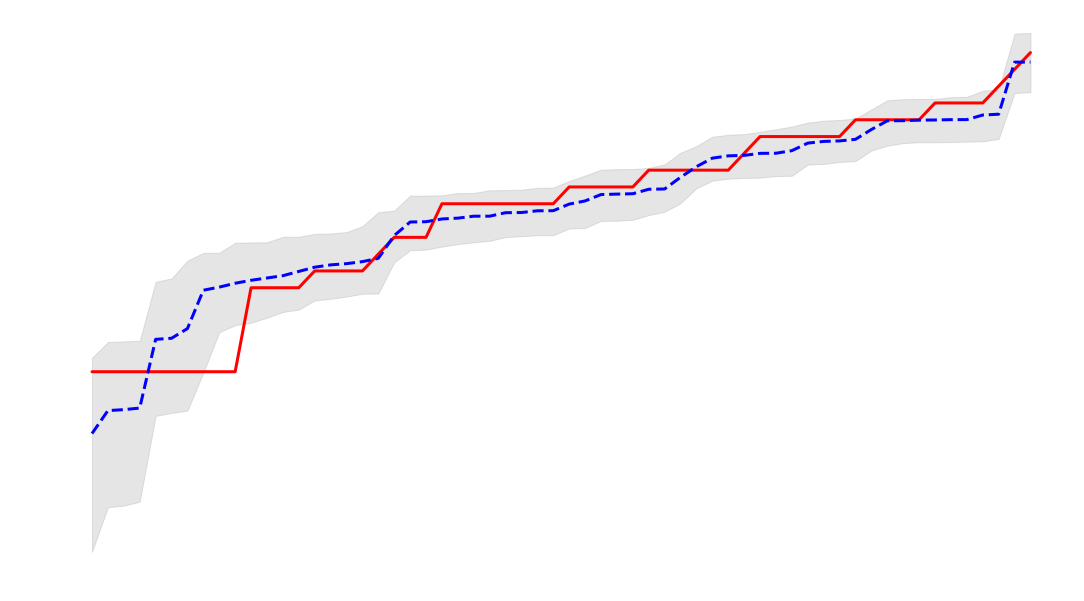

In [132]:
from operator import itemgetter, attrgetter


#we are joining all values


def inverseTransforms (arr :list) -> list :
    """
    As before in order to improve model performance the values were transformed by the Min max and box cox
    transform now in order to retrieve interpretability We will reverse those transformations

    :param arr: array of values we want to transform
    :return: transformed array
    """
    arr = np.array(arr).reshape(-1, 1)
    boxReversed = transFFuther.powTransf.inverse_transform(arr)
    return np.array(mainYScaler.inverse_transform(boxReversed)).flatten()


zipped = np.array(list(zip(valid[1]['G3'].to_numpy(),
paramsCalculated['loc'],
paramsCalculated['loc'] - paramsCalculated['scale'],
paramsCalculated['loc'] + paramsCalculated['scale'] )))


sorted = np.sort(zipped, axis=0)

original = inverseTransforms(list(map(lambda x: x[0] ,sorted  )))
means = inverseTransforms(list(map(lambda x: x[1] ,sorted  )))
loweBound =inverseTransforms( list(map(lambda x: x[2] ,sorted  )))
upperBound =inverseTransforms( list(map(lambda x: x[3] ,sorted  )))


plotmodelResults(original, means,loweBound, upperBound)


In [122]:
df = pd.DataFrame(original,means)
df

,0
-3.189508,0.0
-2.313408,0.0
-2.257463,0.0
-2.163004,0.0
1.926791,0.0
1.992250,0.0
2.696579,0.0
4.852515,0.0
5.036514,0.0
5.266542,0.0


For comparison we will also plot results for model fitted using MSE

ks  KstestResult(statistic=0.12611111111111112, pvalue=0.2815055319186115) MSE 0.14598775333577263


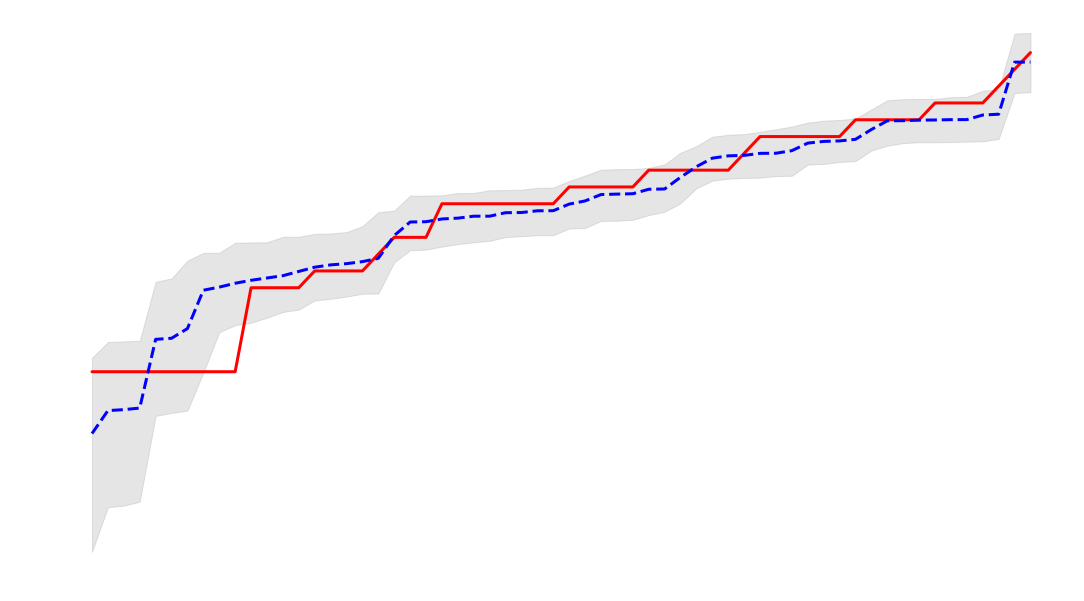

In [133]:
ngbMinMSE =  getModel(bestParamsMSE)

flatValY = valid[1].to_numpy().flatten()
lengthOfValSet = len(flatValY)
Y_preds = ngbMinKs.predict(valid[0])
Y_dists = ngbMinKs.pred_dist(valid[0])
paramsCalculated = Y_dists[0:lengthOfValSet].params
ks = stats.ks_2samp( np.array(ngbMinKs.pred_dist(valid[0]).sample(lengthOfValSet)).flatten() ,flatValY)
mse = mean_squared_error(Y_preds, valid[1])
print("ks ",ks, "MSE",mse  )


zipped = np.array(list(zip(valid[1]['G3'].to_numpy(),
paramsCalculated['loc'],
paramsCalculated['loc'] - paramsCalculated['scale'],
paramsCalculated['loc'] + paramsCalculated['scale'] )))


sorted = np.sort(zipped, axis=0)

original = inverseTransforms(list(map(lambda x: x[0] ,sorted  )))
means = inverseTransforms(list(map(lambda x: x[1] ,sorted  )))
loweBound =inverseTransforms( list(map(lambda x: x[2] ,sorted  )))
upperBound =inverseTransforms( list(map(lambda x: x[3] ,sorted  )))


plotmodelResults(original, means,loweBound, upperBound)




# Feature Importance
Explainabiility of the model is proven to be crucial in implementations of statistical model in real
life situations as it makes the decision makers be able to trust them.

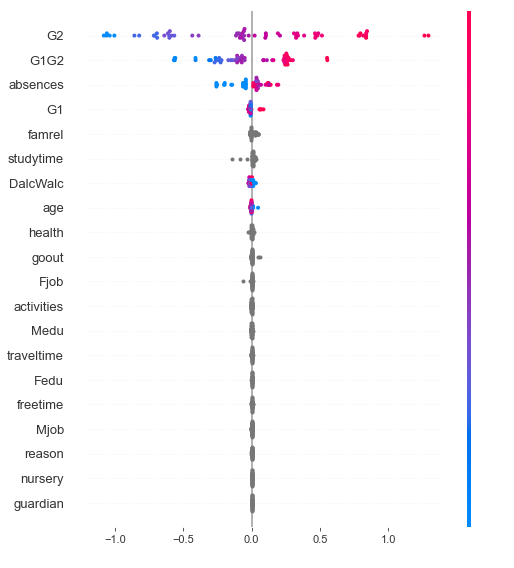

In [124]:
## Feature importance for loc trees
feature_importance_loc = ngbMinKs.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngbMinKs.feature_importances_[1]


shap.initjs()

## SHAP plot for loc trees
explainer = shap.TreeExplainer(ngbMinKs, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(train[0])
shap.summary_plot(shap_values, train[0], feature_names=list(train[0].columns))

## Conlclusions
As was suspected on the basis of the data exploration  there is strong linear relation between dependent and independent variables. This hypothesis is proven also by very low MSE values  achieved by simple linear regression.

NGboost algorithm is very elastic and able to fit well different distributions including linear one, yet what is better NG boost provides model uncertainity information in form of standard deviation (Although probably this could be also achieved via Baysian ridge regression).
It would be also more elastic in case of Dataset Shift. Hyperparameter tuning driven by both MSE
and Komagorov distance metrics provided suprisingly simmilar results, what may be related with
linear (so relatively simple) relations in the dataset.


## Limitations and futher developments
The Biggest mistakes of the model were related with the lower spectrum of the
G3 values, what is related with different support of the regression and target functions.
Changing regression function to such that would have support the same as scaled
 down target variable would be highly beneficial, yet NGboost at the moment of writing do
 not support such distributions (for example beta ... ).
Yet probably sth analogical would be possible to achieve with Pyro library.

Because of relatively small number of possible output values,
classification models could also be explored; simplest example would be to adapt natural gradient
boosting by applying the discrete output probability function.

Another interesting idea would be to apply Baysian network model,
as such models are well suited for categorical data, also discretization required for many algorithm
probably would not lead to significant loss of information in this dataset.

Data exploration could be more revealing if pairwise plots would include all variables,
 including ordinal ones. Also exploration of the association rules could still reveal some hidden
  relations between given states of the categoric variables, what would be particularly important
  in case there would be a decision of developing bayesian network model.

Also in case some decisions will be made on the basis of this changing model to the
 baysian network will enable adding decision nodes, and to incorporate prior knowledge.

In case this model would be used to decide upon school admission it would be also
 necessary to check for model fairness.

In case model would be further developed test,train,validation split should be persisted
 in order to prevent any risk of data leakage.
Also disk cache could be implemented particularly in case of the transformations.
 Part of the code could be parallelized to improve performance.

To reduce the risk of further program mistakes most of global variables should be encapsulated
in the functions or classes, to reduce its accessibility.

Map function in most places could be replaced with list comprehension to increase readability

More unit tests should be implemented and integrated.

instead of simple 2 sample validation implemented k fold test cvalidation should be done.

## Bibliography
[1] R. Steuer, J. Kurths, C. O. Daub, J. Weise, J. Selbig, The mutual information: Detecting and evaluating dependencies between variables, Bioinformatics, Volume 18, Issue suppl_2, October 2002, Pages S231–S240, https://doi.org/10.1093/bioinformatics/18.suppl_2.S231

[2] Vergara, Jorge & Estevez, Pablo. (2014). A Review of Feature Selection Methods Based on Mutual Information. Neural Computing and Applications. 24. 10.1007/s00521-013-1368-0.

[3] Darst, B.F., Malecki, K.C. & Engelman, C.D. Using recursive feature elimination in random forest to account for correlated variables in high dimensional data. BMC Genet 19, 65 (2018). https://doi.org/10.1186/s12863-018-0633-8

[4] Lucena, Brian. (2020). Exploiting Categorical Structure Using Tree-Based Methods.

[5] Duan, Tony & Avati, Anand & Ding, Daisy & Basu, Sanjay & Ng, Andrew & Schuler, Alejandro. (2019). NGBoost: Natural Gradient Boosting for Probabilistic Prediction.

[6] Gardner, Paul & Lord, Charles & Barthorpe, Robert. (2018). An Evaluation of Validation Metrics for Probabilistic Model Outputs. V001T06A001. 10.1115/VVS2018-9327.

[7] Xiao Wei Using KS statistic as a model evaluation metric in Scikit-Learn’s GridSearchCV  https://medium.com/@xiaowei_6531/using-ks-stat-as-a-model-evaluation-metric-in-scikit-learns-gridsearchcv-33135101601c access 20.06.2021 15:15

[8] Wang, Zhen. (2018). “Automatic Hyperparameter Tuning of Machine Learning Models under Time Constraints".

